In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from statsmodels.stats import multitest
import sys
sys.path.append("/Users/erankotler/Google Drive/workspace/General_funcs")
import Volcano_plot
from GSEA import GSEA, plt_gsea_results
%matplotlib inline

### Parameters

In [2]:
data_d = "/Users/erankotler/Google Drive/workspace/CMV/Data/RNAseq"
output_dir = "/Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output"

deseq_f = os.path.join(data_d,"de_stats.csv") # DEseq stats file

In [3]:
deseq = pd.read_csv(deseq_f, index_col=0) # Load DESeq statistics
comparisons = list(deseq.index.unique()) # List of all 6 pairwise comparisons 
comparisons

['IE1wt_CMV_vs_IE1dCTD_CMV',
 'IE1wt_CMV_vs_Luc_CMV',
 'IE1wt_CMV_vs_Luc_Mock',
 'IE1dCTD_CMV_vs_Luc_CMV',
 'IE1dCTD_CMV_vs_Luc_Mock',
 'Luc_CMV_vs_Luc_Mock']

### Volcano plots
plot DE genes and save lists of up/down regulated genes in each comparison

/Users/erankotler/Google Drive/workspace/General_funcs/Volcano_plot.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  deseq_df["sig"] = deseq_df["padj"]
/Users/erankotler/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


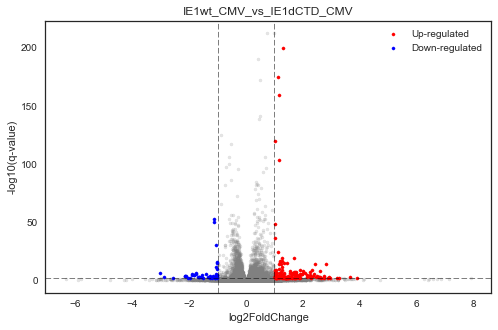

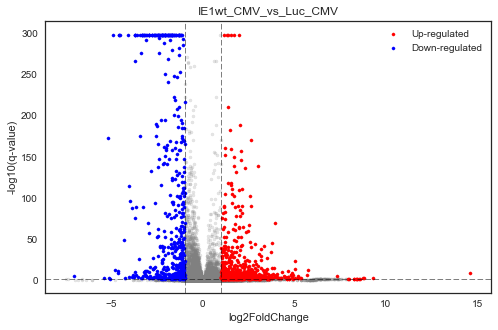

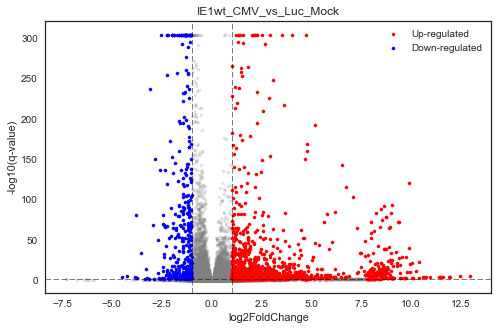

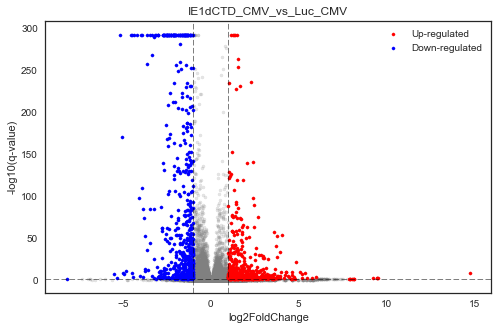

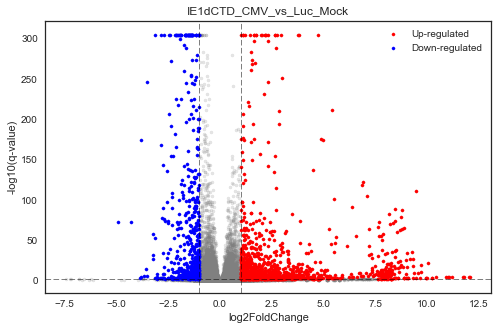

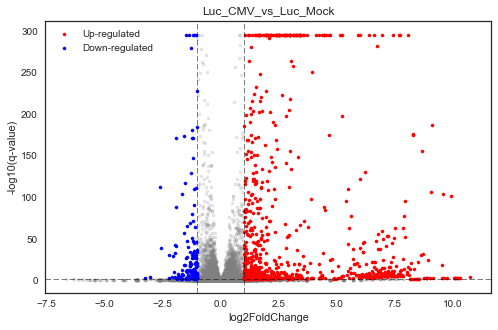

In [4]:
for comparison in comparisons:
    df = deseq.loc[comparison, :] # Look at specific comparison

    f, sig_up, sig_dwn = Volcano_plot.volcano_plt(df, q_thresh=0.01, logfold_thresh=1)
    plt.title(comparison)
    # ax = f.gca()
    # ax.set_ylim([0,10]) # Zoom in on yaxis

    # Save files
    plt.savefig(os.path.join(output_dir, "volcano_{comp}.png".format(comp=comparison)))
    sig_up.to_csv(os.path.join(output_dir,comparison + "_VolcUp.csv"))
    sig_dwn.to_csv(os.path.join(output_dir,comparison + "_VolcDwn.csv"))

    plt.show()

### Add Gene names corresponding to Ensembl IDs 
Conversion table downloaded from BioMart - https://www.ensembl.org/biomart/martview/145bf30afa49992aa04334500714cfed


In [9]:
Gene_ID_conv_f = "/Users/erankotler/Google Drive/workspace/CMV/Data/Gene_ID_conversions/BioMart_Conversion.csv" 
conv = pd.read_csv(Gene_ID_conv_f, index_col=2).drop("Transcript stable ID", axis=1)
conv = conv.drop_duplicates()
deseq_known_IDs = pd.merge(left = deseq, right=conv, left_on="Gene", right_index=True, how='inner')
deseq_known_IDs["Gene"] = deseq_known_IDs["Gene name"]
deseq_known_IDs.drop("Gene name", axis=1, inplace=True)
deseq_known_IDs.to_csv(os.path.join(data_d,"de_stats_ConvertedGeneNames.csv"))

for c in comparisons:
    d = deseq_known_IDs.loc[c, :]
    d.index = d["Gene"]
    d = d.drop("Gene", axis=1)
    d.to_csv(os.path.join(data_d,"{comp}_de_stats_ConvertedGeneNames.csv".format(comp=c)))

### Gene Set analysis
* Using an adaptation of GSEA - compare the scores of genes in each gene-set to that of genes outside the gene-set 
* Here I used the log2fold-change as the score for comparison, zeroing-out scores of non-significant genes (FDR>0.05)

csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_IE1wt_CMV_vs_IE1dCTD_CMV_HM.csv
csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_IE1wt_CMV_vs_Luc_CMV_HM.csv
csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_IE1wt_CMV_vs_Luc_Mock_HM.csv
csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_IE1dCTD_CMV_vs_Luc_CMV_HM.csv
csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_IE1dCTD_CMV_vs_Luc_Mock_HM.csv
csv file saved to /Users/erankotler/Google Drive/workspace/CMV/ChIP_vs_Exp_output/GSEA_Luc_CMV_vs_Luc_Mock_HM.csv


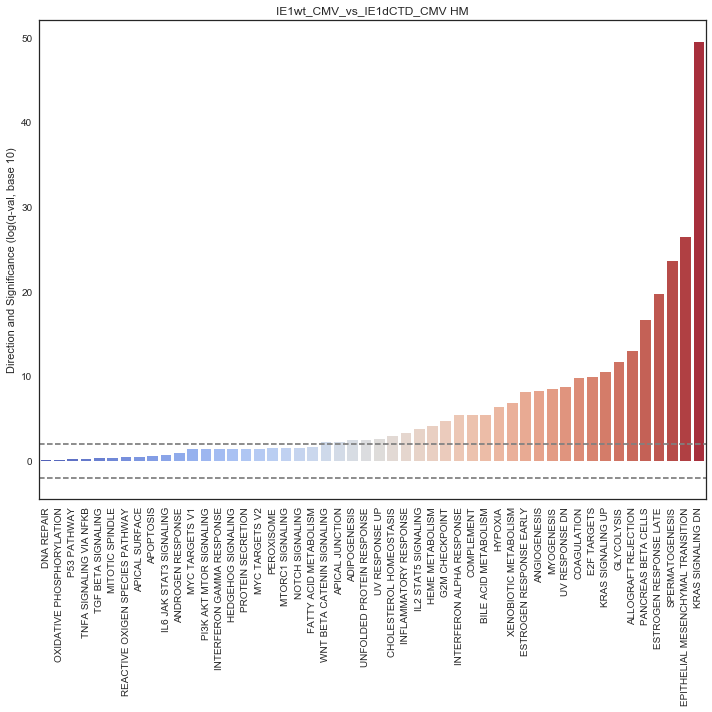

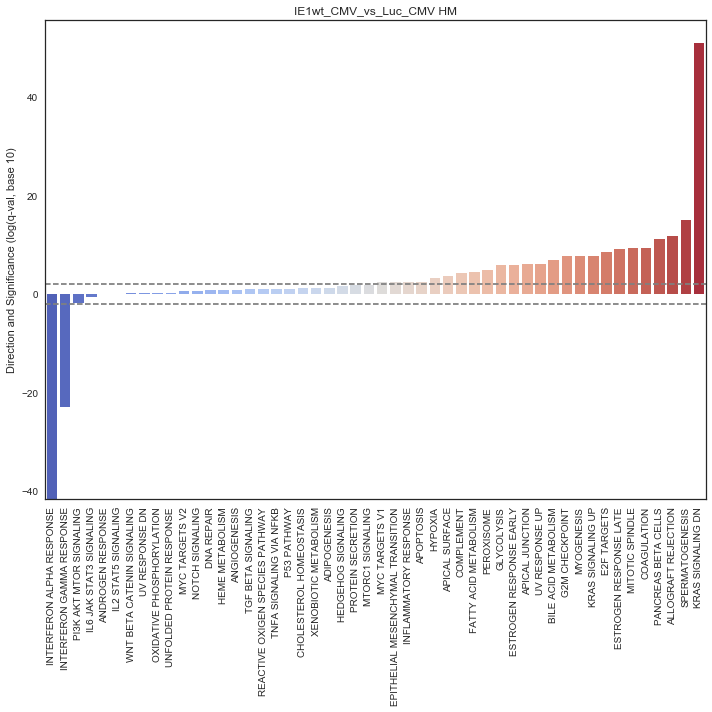

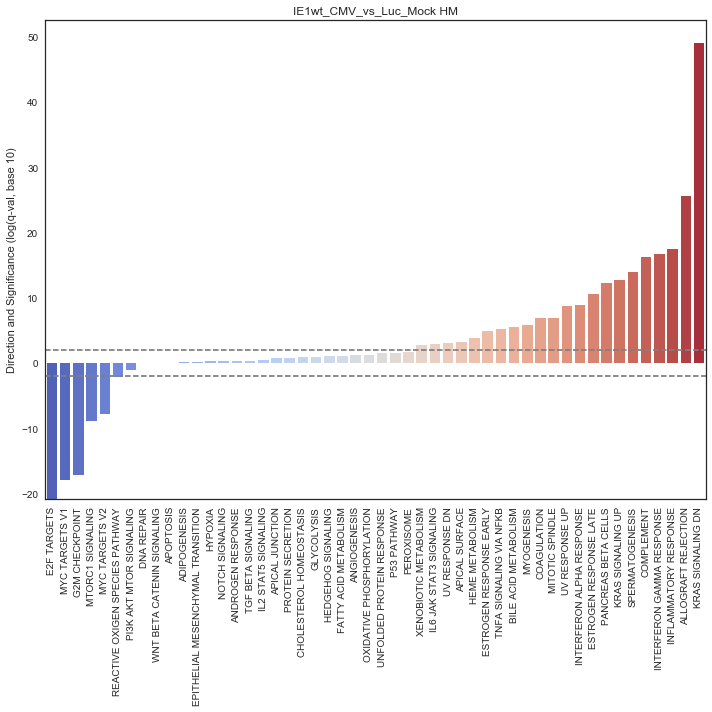

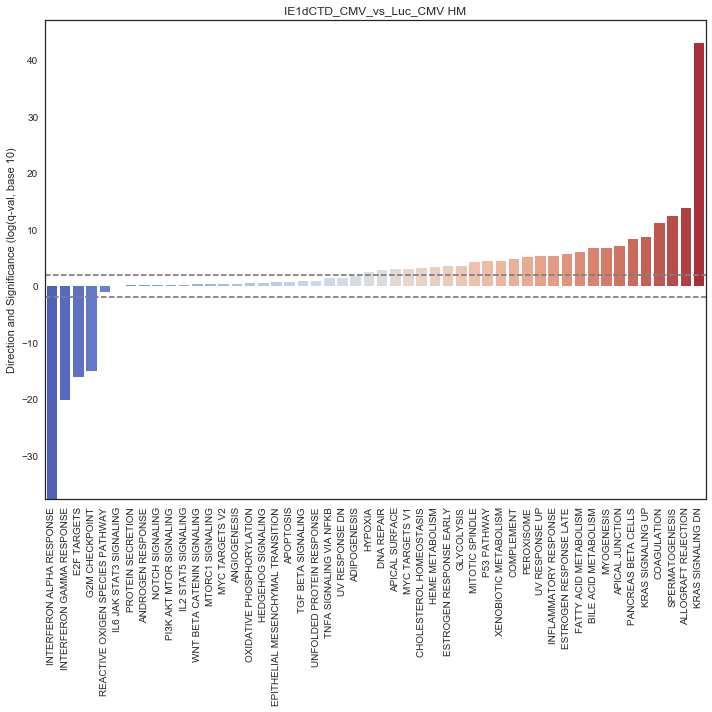

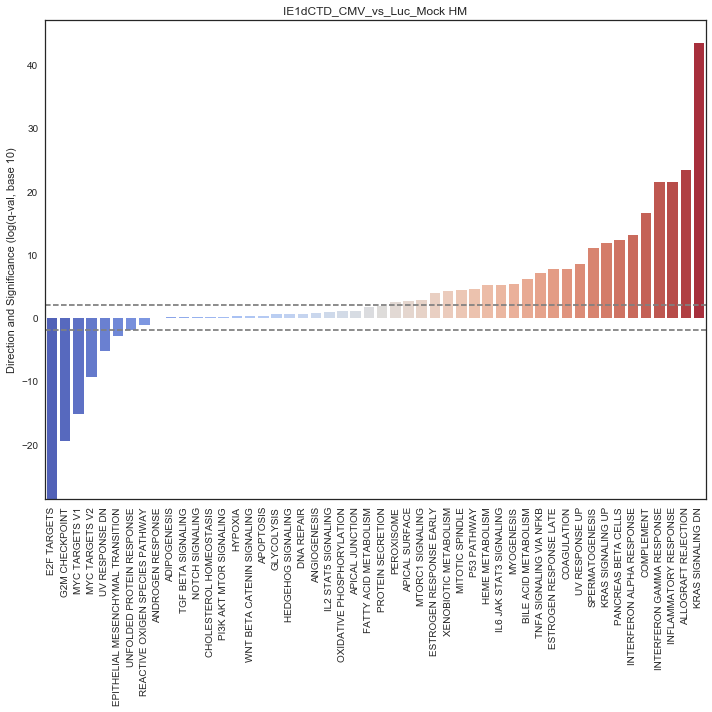

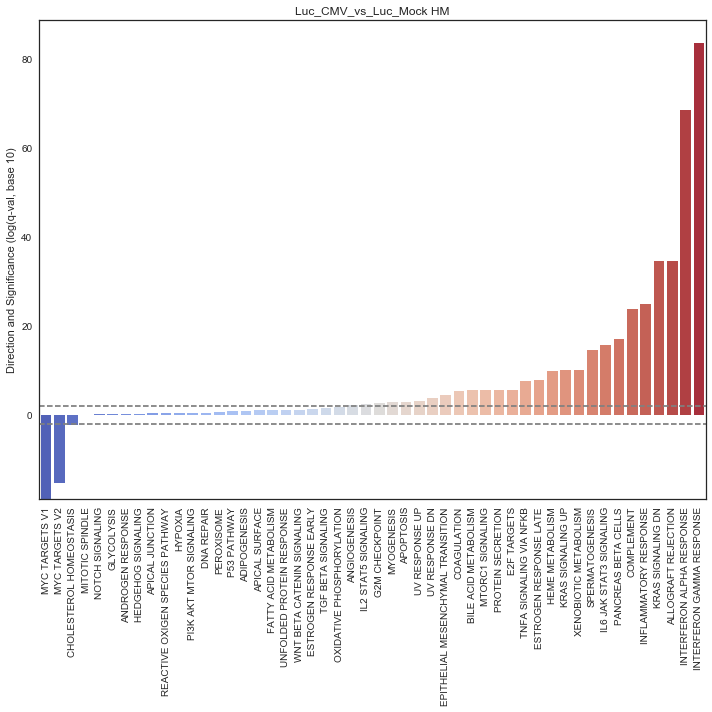

In [10]:
gsea_d = output_dir
GS_collection = "HM" # Gene-set collection to use - Hallmark gene sets (quick and better)

for comp in comparisons:
    # Organize file names:
    diff_exp_f = os.path.join(data_d,"{comp}_de_stats_ConvertedGeneNames.csv".format(comp=comp))
    gsea_fname_pfx = "GSEA_"+ comp + "_" + GS_collection
    gsea_csv_f = os.path.join(gsea_d, gsea_fname_pfx + ".csv")
    gsea_png_f = os.path.join(gsea_d, gsea_fname_pfx + ".pdf")    

    # Calculate gene-set enrichments and save to csv
    gs_enrrichment = GSEA(diff_exp_f, GeneSets=GS_collection, output_f=gsea_csv_f, verbose=False, \
                          fill_zeros=True, score="FoldChange")

    # Plot GSEA results and save to png 
    plt_title = " ".join([comp, GS_collection])
    f = plt_gsea_results(gs_enrrichment, title=plt_title, output_f=gsea_png_f, 
                         qval_thresh=0.01, min_overlap=20, max_sets=50, verbose=False, dpi=300)
